In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
train_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Train.csv')
test_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Test.csv')
sample_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/SampleSubmission.csv')

### Try Basic Feature Engineering

In [3]:
# # Categorical features
# cat_cols = ['File']
# df = pd.get_dummies(train_data, columns=cat_cols)

In [4]:
# Extract Cooling and Lights from random Mesures feature
train_data[['Cooling', 'Lights']] = train_data['random load mesures'].str.extract(r'Cooling\': \'(?P<Cooling>[0-9\.]+):C\', \'Lights\': \'(?P<Lights>[0-9\.]+):C')
test_data[['Cooling', 'Lights']] = test_data['random load mesures'].str.extract(r'Cooling\': \'(?P<Cooling>[0-9\.]+):C\', \'Lights\': \'(?P<Lights>[0-9\.]+):C')

In [5]:
train_data[['Cooling', 'Lights']] = train_data[['Cooling', 'Lights']].astype(float)
test_data[['Cooling', 'Lights']]= test_data[['Cooling', 'Lights']].astype(float)

In [6]:
train_data.drop(columns={'random load mesures'}, inplace= True)
test_data.drop(columns={'random load mesures'}, inplace= True)

In [7]:
wwr = []
from statistics import mean
for x in train_data['WWR']: 
     
    test_map = x.replace('(' , '').replace(')' , '')
    tupe = tuple(map(float, test_map.split(',')))
    wwr.append(mean(tupe)) 
train_data['WWR'] = wwr

In [8]:
wwr = []
for x in test_data['WWR']: 
     
    test_map = x.replace('(' , '').replace(')' , '')
    tupe = tuple(map(float, test_map.split(',')))
    wwr.append(mean(tupe)) 
test_data['WWR'] = wwr

In [9]:
# Interaction terms 
# calculate the window resistance using the wwr and window resistance thermal

train_data['Window_Resistance'] = train_data['Windows Rt'] * train_data['WWR']
test_data['Window_Resistance'] = test_data['Windows Rt'] * test_data['WWR']

In [10]:
# # calculate the overall thermal resistance
# cols = ['Internal Wall Rt', 'Internal Floor Rt', 'Ground Floor Rt', 'Wall Rt', 'Roof Rt']
# for col in cols:
#     train_data['avg_Rt']= train_data[col].apply(lambda x: x.mean())
# # test_data['avg_Rt'] =  test_data[cols].apply(lambda x: x.mean())

In [11]:
train_data.columns

Index(['building', 'File', 'Cooling Setpoint', 'EUI', 'Cooling COP',
       'Operating Hours', 'WWR', 'Equipment Heat Gain', 'Internal Wall Rt',
       'Internal Floor Rt', 'Infiltration', 'Ground Floor Rt',
       'Number of Floors', 'Occupancy', 'Light Heat Gain', 'Windows Rt',
       'Height', 'Heating COP', 'Heating Setpoint', 'Town', 'Wall Rt',
       'Start Time', 'windows g-value', 'Roof Rt', 'Boiler Efficiency',
       'Internal Mass', 'Permeability', 'Total Floors Area',
       'Operational Energy', 'Cooling', 'Lights', 'Window_Resistance'],
      dtype='object')

In [12]:
train_data.dtypes

building                object
File                    object
Cooling Setpoint       float64
EUI                    float64
Cooling COP            float64
Operating Hours        float64
WWR                    float64
Equipment Heat Gain    float64
Internal Wall Rt       float64
Internal Floor Rt      float64
Infiltration           float64
Ground Floor Rt        float64
Number of Floors         int64
Occupancy              float64
Light Heat Gain        float64
Windows Rt             float64
Height                 float64
Heating COP            float64
Heating Setpoint       float64
Town                     int64
Wall Rt                float64
Start Time             float64
windows g-value        float64
Roof Rt                float64
Boiler Efficiency      float64
Internal Mass          float64
Permeability           float64
Total Floors Area      float64
Operational Energy     float64
Cooling                float64
Lights                 float64
Window_Resistance      float64
dtype: o

In [13]:
# Feature scaling and aggregation
num_cols = ['Cooling Setpoint', 'EUI', 'Cooling COP',
       'Operating Hours', 'WWR', 'Equipment Heat Gain', 'Internal Wall Rt',
       'Internal Floor Rt', 'Infiltration', 'Ground Floor Rt',
       'Number of Floors', 'Occupancy', 'Light Heat Gain', 'Windows Rt',
       'Height', 'Heating COP', 'Heating Setpoint', 'Wall Rt',
       'Start Time', 'windows g-value', 'Roof Rt', 'Boiler Efficiency',
       'Internal Mass', 'Permeability', 'Total Floors Area', 'Cooling', 'Lights', 'Window_Resistance']
scaler = MinMaxScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])

In [14]:
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])

In [15]:
# PCA feature extraction
pca_cols = ['Internal Wall Rt', 'Internal Floor Rt', 'Infiltration', 'Ground Floor Rt', 'Wall Rt', 'Roof Rt']
pca = PCA(n_components=1, random_state=42)
train_data['PCA'] = pca.fit_transform(train_data[pca_cols])
test_data['PCA'] = pca.fit_transform(test_data[pca_cols])

In [16]:
# Remove original columns
train_data = train_data.drop(columns=pca_cols)
test_data = test_data.drop(columns=pca_cols)

In [17]:
train_data.columns

Index(['building', 'File', 'Cooling Setpoint', 'EUI', 'Cooling COP',
       'Operating Hours', 'WWR', 'Equipment Heat Gain', 'Number of Floors',
       'Occupancy', 'Light Heat Gain', 'Windows Rt', 'Height', 'Heating COP',
       'Heating Setpoint', 'Town', 'Start Time', 'windows g-value',
       'Boiler Efficiency', 'Internal Mass', 'Permeability',
       'Total Floors Area', 'Operational Energy', 'Cooling', 'Lights',
       'Window_Resistance', 'PCA'],
      dtype='object')

### Model XGboost

In [18]:
ids = train_data['building']
ids_test = test_data['building']

In [19]:
train_data.drop(columns={'building', 'File'}, inplace= True)
test_data.drop(columns={'building', 'File'}, inplace= True)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Operational Energy', axis=1), train_data['Operational Energy'], test_size=0.2, random_state=42)

In [21]:
# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

In [22]:
# Fit the pipeline to the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [23]:
score = model.score(X_test, y_test)
print('R2', score)


R2 0.9971572888931373


In [24]:
test = model.predict(test_data)

In [25]:
test_set_with_id = pd.concat([ids_test.iloc[test_data.index], test_data], axis=1)

In [26]:
# Add the predicted target variable to the data frame
test_set_with_id['Predicted Target'] = test

In [27]:
test_set_with_id['ID'] = test_set_with_id.apply(lambda x: f"Building_{x['building'].split('_')[1]}_Town_{x['Town']}", axis=1)

In [28]:
test_set_with_id.columns

Index(['building', 'Cooling Setpoint', 'EUI', 'Cooling COP', 'Operating Hours',
       'WWR', 'Equipment Heat Gain', 'Number of Floors', 'Occupancy',
       'Light Heat Gain', 'Windows Rt', 'Height', 'Heating COP',
       'Heating Setpoint', 'Town', 'Start Time', 'windows g-value',
       'Boiler Efficiency', 'Internal Mass', 'Permeability',
       'Total Floors Area', 'Cooling', 'Lights', 'Window_Resistance', 'PCA',
       'Predicted Target', 'ID'],
      dtype='object')

In [29]:
test_set_with_id.drop(columns={'building', 'Cooling Setpoint', 'EUI', 'Cooling COP', 'Operating Hours',
       'WWR', 'Equipment Heat Gain', 'Number of Floors', 'Occupancy',
       'Light Heat Gain', 'Windows Rt', 'Height', 'Heating COP',
       'Heating Setpoint', 'Town', 'Start Time', 'windows g-value',
       'Boiler Efficiency', 'Internal Mass', 'Permeability',
       'Total Floors Area', 'Cooling', 'Lights', 'Window_Resistance', 'PCA'}, inplace= True)

In [30]:
submission = test_set_with_id[['ID', 'Predicted Target']]

In [31]:
submission.head()

,ID,Predicted Target
0,Building_1_Town_1,417064.46875
1,Building_100_Town_1,419048.15625
2,Building_1000_Town_2,421953.65625
3,Building_10000_Town_0,418373.68750
4,Building_10005_Town_2,420335.34375


In [32]:
submission.to_csv('submission5.csv', index= False)

### First Attempt

In [ ]:
test['ID'] = test.apply(lambda x: f"Building_{x['building'].split('_')[1]}_Town_{x['Town']}", axis=1)

In [ ]:
train_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Train.csv')
test_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/Test.csv')
sample_data = pd.read_csv('C:/Users/tun20/Desktop/Hackathons/AI Hackflow/SampleSubmission.csv')

In [ ]:
train_data.head()

,building,File,Cooling Setpoint,EUI,Cooling COP,Operating Hours,WWR,Equipment Heat Gain,Internal Wall Rt,Internal Floor Rt,Infiltration,Ground Floor Rt,Number of Floors,Occupancy,Light Heat Gain,Windows Rt,Height,Heating COP,Heating Setpoint,Town,Wall Rt,Start Time,windows g-value,Roof Rt,Boiler Efficiency,Internal Mass,Permeability,Total Floors Area,random load mesures,Operational Energy
0,Building_0,Shape0_10851,26.804565,37.155511,4.430542,12.166667,"(0.771636962890625,0.436004638671875,0.5746520...",15.463379,2.511920,1.919918,0.210,3.445636,5,23.231812,7.946655,1.147765,3.351489,2.927368,19.373901,1,4.640045,8.778931,0.381354,2.912090,0.921890,44.441528,3.942261,18210.25,"{'Cooling': '6743.0007375945:C', 'Lights': '10...",135322.229618
1,Building_10,Shape0_11866,25.219604,64.131327,2.855347,9.166667,"(0.451275634765625,0.061151123046875,0.2780212...",11.646973,2.080851,2.822443,0.222,3.484326,5,19.027710,4.105835,1.062551,4.118481,2.891235,20.949097,0,3.621094,8.131470,0.556696,4.019824,0.908726,41.702271,5.122925,13110.25,"{'Cooling': '6485.8495970786:C', 'Lights': '31...",168155.546796
2,Building_10001,Shape0_15816,26.691040,31.992473,2.863892,10.166667,"(0.324163818359375,0.669464111328125,0.6951721...",9.899902,2.274071,2.341140,0.221,5.081571,4,20.664673,4.587036,1.162571,3.247339,3.647339,19.816528,1,4.595792,7.406128,0.572552,5.745949,0.911157,24.244995,4.495239,13561.60,"{'Cooling': '3861.976104307:C', 'Lights': '486...",108467.281862
3,Building_10002,Shape0_15566,25.468384,40.932114,3.922485,10.333333,"(0.772406005859375,0.924346923828125,0.5703674...",12.196777,2.541613,2.390324,0.245,3.329946,5,19.004517,6.005005,1.176192,3.699683,3.643433,20.390747,1,5.310859,7.831909,0.520404,4.394614,0.929751,24.655151,6.311646,21678.00,"{'Cooling': '10788.0922449597:C', 'Lights': '7...",177465.271945
4,Building_10003,Shape0_3155,25.152832,57.792356,2.828613,10.833333,"(0.3538818359375,0.2387451171875,0.07746582031...",12.552734,1.586183,2.228146,0.313,3.493092,4,18.679199,5.554199,1.149819,3.442090,4.364746,20.411621,2,4.190710,8.794434,0.475854,5.271557,0.947480,29.201660,7.530762,14200.16,"{'Cooling': '4314.2210067885:C', 'Lights': '59...",205165.175932


In [ ]:
test_data.head()

,building,File,Cooling Setpoint,EUI,Cooling COP,Operating Hours,WWR,Equipment Heat Gain,Internal Wall Rt,Internal Floor Rt,Infiltration,Ground Floor Rt,Number of Floors,Occupancy,Light Heat Gain,Windows Rt,Height,Heating COP,Heating Setpoint,Town,Wall Rt,Start Time,windows g-value,Roof Rt,Boiler Efficiency,Internal Mass,Permeability,Total Floors Area,random load mesures
0,Building_1,Shape0_6003,25.371338,48.450552,2.972900,12.000000,"(0.25291748046875,0.69324951171875,0.400573730...",10.346680,2.298476,1.580948,0.230,2.859736,3,15.418701,6.540771,1.106982,3.390088,3.510986,19.674561,1,3.674531,7.916260,0.387854,4.349581,0.905850,24.708252,3.960205,4523.94,"{'Cooling': '1643.8350830999:C', 'Lights': '35..."
1,Building_100,Shape0_369,25.034217,39.219867,3.983462,9.166667,"(0.911370555782949,0.778347991157967,0.1507843...",14.214766,1.941513,2.070646,0.272,3.664181,4,16.092621,4.684525,1.233918,3.125073,3.451234,20.981460,1,6.259573,7.043643,0.395789,3.625850,0.963632,25.543847,5.926628,10876.48,"{'Cooling': '5289.2784613186:C', 'Lights': '37..."
2,Building_1000,Shape0_632,25.173828,62.887801,2.736328,12.166667,"(0.68720703125,0.08427734375,0.92275390625,0.6...",13.398438,1.817859,2.191312,0.317,3.567944,3,22.216797,4.416016,1.176065,3.162891,3.236328,20.623047,2,5.350052,8.642578,0.529980,6.555698,0.938828,27.744141,5.853516,4232.25,"{'Cooling': '4704.1961872611:C', 'Lights': '21..."
3,Building_10000,Shape0_7548,25.193115,69.128493,4.458740,13.333333,"(0.94263916015625,0.14986572265625,0.168762207...",11.625977,1.846750,2.535359,0.280,3.054665,6,15.074463,7.635010,1.088016,3.317725,4.103271,20.277588,0,6.375097,8.576904,0.392322,3.280211,0.979033,42.161865,6.627686,29940.12,"{'Cooling': '9207.8039080741:C', 'Lights': '15..."
4,Building_10005,Shape0_934,25.254967,52.557239,3.002524,9.000000,"(0.803705120894803,0.513499464549676,0.2460407...",9.034523,2.308631,1.987770,0.266,5.034052,6,19.772205,6.046424,1.133272,3.179721,3.882624,19.546709,2,3.249097,8.190305,0.506399,6.460178,0.906366,19.061121,6.711195,27435.24,"{'Cooling': '10630.3887968416:C', 'Lights': '7..."


In [ ]:
train_data.describe()

,Cooling Setpoint,EUI,Cooling COP,Operating Hours,Equipment Heat Gain,Internal Wall Rt,Internal Floor Rt,Infiltration,Ground Floor Rt,Number of Floors,Occupancy,Light Heat Gain,Windows Rt,Height,Heating COP,Heating Setpoint,Town,Wall Rt,Start Time,windows g-value,Roof Rt,Boiler Efficiency,Internal Mass,Permeability,Total Floors Area,Operational Energy
count,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000,54600.000000
mean,26.000114,56.713766,3.499182,11.318828,12.000162,2.063230,2.063373,0.270585,4.237292,4.484780,19.995678,6.997699,1.189008,3.600766,3.499419,20.000086,1.000000,4.235788,7.999593,0.449978,4.235396,0.939971,29.985699,6.001596,14306.061487,165252.370240
std,0.577127,12.760431,0.577278,1.796210,2.307975,0.371027,0.371210,0.057913,1.049585,1.156924,2.887201,1.733704,0.122699,0.346275,0.577349,0.577069,0.816504,1.048261,0.577424,0.086571,1.047853,0.023109,8.662488,1.731537,7922.612042,65056.005167
min,25.000000,23.014628,2.500000,8.000000,8.000000,1.538483,1.538483,0.163000,2.857184,2.000000,15.000000,4.000000,1.000018,3.000000,2.500000,19.000000,0.000000,2.857193,7.000000,0.300000,2.857292,0.900000,15.000000,3.000000,1999.880000,32780.873847
25%,25.499985,47.437526,2.999603,9.833333,10.001282,1.739241,1.739068,0.225000,3.333147,4.000000,17.495041,5.496017,1.081052,3.300833,2.999435,19.501144,0.000000,3.333622,7.499008,0.375025,3.333316,0.919938,22.470932,4.502838,7320.500000,113395.250360
50%,25.999786,55.786021,3.498932,11.333333,11.999146,1.999689,1.999799,0.266000,4.000098,5.000000,19.994049,6.995880,1.176534,3.601105,3.499115,19.999786,1.000000,3.998780,7.999969,0.449913,3.999268,0.939963,29.985809,6.003937,12943.840000,159507.258354
75%,26.499893,64.999304,3.998978,12.833333,13.996948,2.352675,2.352599,0.309000,5.002175,5.000000,22.493766,8.501465,1.290479,3.900779,3.999405,20.499252,2.000000,4.998360,8.498764,0.524993,4.998741,0.960001,37.495193,7.501144,20323.500000,210194.386728
max,26.999939,113.635186,4.499939,14.833333,15.999756,2.857143,2.857143,0.520000,6.666667,6.000000,24.999695,9.999817,1.428571,4.199963,4.499939,20.999939,2.000000,6.666667,8.999939,0.599991,6.666667,0.979998,44.998169,8.999634,30000.960000,423444.390589


<AxesSubplot:xlabel='Operational Energy'>

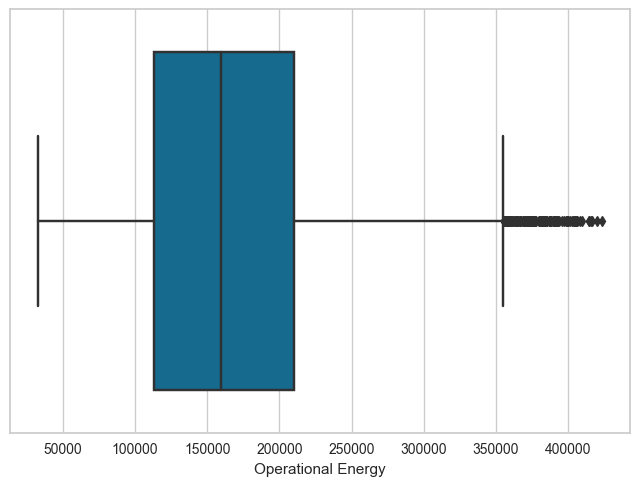

In [ ]:
sns.boxplot(train_data['Operational Energy'])

In [ ]:
train_data['EUI'].nunique()

54600

<AxesSubplot:xlabel='EUI'>

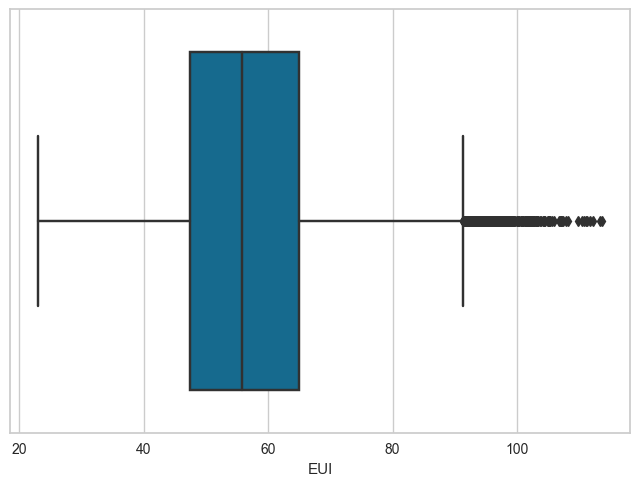

In [ ]:
sns.boxplot(train_data['EUI'])

In [ ]:
train_data['File'].nunique()

17907

In [ ]:
train_data[['Cooling', 'Lights']] = train_data['random load mesures'].str.extract(r'Cooling\': \'(?P<Cooling>[0-9\.]+):C\', \'Lights\': \'(?P<Lights>[0-9\.]+):C')


In [ ]:
train_data.head()

,building,File,Cooling Setpoint,EUI,Cooling COP,Operating Hours,WWR,Equipment Heat Gain,Internal Wall Rt,Internal Floor Rt,Infiltration,Ground Floor Rt,Number of Floors,Occupancy,Light Heat Gain,Windows Rt,Height,Heating COP,Heating Setpoint,Town,Wall Rt,Start Time,windows g-value,Roof Rt,Boiler Efficiency,Internal Mass,Permeability,Total Floors Area,random load mesures,Operational Energy,Cooling,Lights
0,Building_0,Shape0_10851,26.804565,37.155511,4.430542,12.166667,"(0.771636962890625,0.436004638671875,0.5746520...",15.463379,2.511920,1.919918,0.210,3.445636,5,23.231812,7.946655,1.147765,3.351489,2.927368,19.373901,1,4.640045,8.778931,0.381354,2.912090,0.921890,44.441528,3.942261,18210.25,"{'Cooling': '6743.0007375945:C', 'Lights': '10...",135322.229618,6743.0007375945,10475.8242194357
1,Building_10,Shape0_11866,25.219604,64.131327,2.855347,9.166667,"(0.451275634765625,0.061151123046875,0.2780212...",11.646973,2.080851,2.822443,0.222,3.484326,5,19.027710,4.105835,1.062551,4.118481,2.891235,20.949097,0,3.621094,8.131470,0.556696,4.019824,0.908726,41.702271,5.122925,13110.25,"{'Cooling': '6485.8495970786:C', 'Lights': '31...",168155.546796,6485.8495970786,3108.6393776116
2,Building_10001,Shape0_15816,26.691040,31.992473,2.863892,10.166667,"(0.324163818359375,0.669464111328125,0.6951721...",9.899902,2.274071,2.341140,0.221,5.081571,4,20.664673,4.587036,1.162571,3.247339,3.647339,19.816528,1,4.595792,7.406128,0.572552,5.745949,0.911157,24.244995,4.495239,13561.60,"{'Cooling': '3861.976104307:C', 'Lights': '486...",108467.281862,3861.976104307,4866.3554470021
3,Building_10002,Shape0_15566,25.468384,40.932114,3.922485,10.333333,"(0.772406005859375,0.924346923828125,0.5703674...",12.196777,2.541613,2.390324,0.245,3.329946,5,19.004517,6.005005,1.176192,3.699683,3.643433,20.390747,1,5.310859,7.831909,0.520404,4.394614,0.929751,24.655151,6.311646,21678.00,"{'Cooling': '10788.0922449597:C', 'Lights': '7...",177465.271945,10788.0922449597,7679.3110516732
4,Building_10003,Shape0_3155,25.152832,57.792356,2.828613,10.833333,"(0.3538818359375,0.2387451171875,0.07746582031...",12.552734,1.586183,2.228146,0.313,3.493092,4,18.679199,5.554199,1.149819,3.442090,4.364746,20.411621,2,4.190710,8.794434,0.475854,5.271557,0.947480,29.201660,7.530762,14200.16,"{'Cooling': '4314.2210067885:C', 'Lights': '59...",205165.175932,4314.2210067885,5904.9603140156


In [ ]:
train_data.drop(columns={'random load mesures'}, inplace= True)

In [ ]:
report = ProfileReport(train_data)

In [ ]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 